# broken coference chains (connected components) in PCC

repo: ~/repos/pcc-development-repo  
commit 872ef40c435f2d67c6cd45f51e396767b92ba005  
Date:   Sat Jan 24 11:18:25 2015 +0100

In [54]:
# %load_ext gvmagic

In [10]:
import os
import glob
from itertools import combinations

import discoursegraphs as dg

MMAX_DIR = os.path.expanduser('~/repos/pcc-development-repo/maz176/coreference/')

## get all mmax documents in which a markable occurs in more than one coreference chain

In [12]:
def get_ambiguous_markables(mmax_docgraph):
    """returns a list of markables that occur in more than one coreference chain"""
    ambiguous_markables = []
    chain_sets = (set(chain) for chain in dg.get_pointing_chains(mmax_docgraph))
    for chain1, chain2 in combinations(chain_sets, 2):
        chain_intersect = chain1.intersection(chain2)
        if chain_intersect:
            ambiguous_markables.extend(chain_intersect)
    return ambiguous_markables

In [16]:
files_with_ambigious_chains = {}
for mmax_file in glob.glob(os.path.join(MMAX_DIR, '*.mmax')):
    mdg = dg.read_mmax2(mmax_file)
    ambigous_markables = get_ambiguous_markables(mdg)
    if ambigous_markables:
        files_with_ambigious_chains[mmax_file] = ambigous_markables

In [17]:
len(files_with_ambigious_chains)

25

In [22]:
# for filename in files_with_ambigious_chains:
#     print os.path.basename(filename), len(files_with_ambigious_chains[filename])

from operator import itemgetter

In [34]:
sorted([(os.path.basename(fpath), len(ambig_elems))
        for (fpath, ambig_elems) in files_with_ambigious_chains.items()],
       key=itemgetter(1), reverse=True)

[('maz-11299.mmax', 70),
 ('maz-19074.mmax', 9),
 ('maz-10205.mmax', 7),
 ('maz-9884.mmax', 7),
 ('maz-00001.mmax', 6),
 ('maz-18712.mmax', 4),
 ('maz-1453.mmax', 3),
 ('maz-16294.mmax', 3),
 ('maz-13915.mmax', 3),
 ('maz-17539.mmax', 2),
 ('maz-14399.mmax', 2),
 ('maz-8134.mmax', 2),
 ('maz-18171.mmax', 2),
 ('maz-10207.mmax', 2),
 ('maz-18354.mmax', 2),
 ('maz-12576.mmax', 2),
 ('maz-6728.mmax', 2),
 ('maz-18480.mmax', 1),
 ('maz-19372.mmax', 1),
 ('maz-6488.mmax', 1),
 ('maz-18377.mmax', 1),
 ('maz-3377.mmax', 1),
 ('maz-3073.mmax', 1),
 ('maz-2611.mmax', 1),
 ('maz-16987.mmax', 1)]

## Visualizing ambiguous coreference annotations with discoursegraphs

In [39]:
from collections import defaultdict
import networkx as nx

from discoursegraphs import get_text

def get_ambiguous_chains(mmax_docgraph, token_labels=False):
    """
    Returns a list of networkx graphs that represent ambiguous
    coreference chains. An ambiguous chain represents two or more
    coreference chains that share at least one markable.
    
    There should be no ambiguous coreference chains, but the
    current version of our annotation guidelines allow them. // SRSLY?
    """
    ambiguous_markables = get_ambiguous_markables(mmax_docgraph)    
    coreference_chains = dg.get_pointing_chains(mmax_docgraph)
    markable2chain = defaultdict(list)
    for i, chain in enumerate(coreference_chains):
        for markable in chain:
            if markable in ambiguous_markables:
                markable2chain[markable].append(i)
    
    chain_graphs = []
    for markable in markable2chain:
        ambig_chain_ids = markable2chain[markable]
        chain_graph = nx.MultiDiGraph()
        chain_graph.name = mmax_docgraph.name
        for chain_id in ambig_chain_ids:
            ambig_chain = coreference_chains[chain_id]
            for i, markable in enumerate(ambig_chain[:-1]):
                chain_graph.add_edge(markable, ambig_chain[i+1])

        if token_labels:
            for markable in chain_graph.nodes_iter():
                markable_text = get_text(mmax_docgraph, markable)
                chain_graph.node[markable]['label'] = markable_text
        
        chain_graphs.append(chain_graph)
    return chain_graphs

In [71]:
# docs_with_ambiguous_chains = {}

# for mmax_file in glob.glob(os.path.join(MMAX_DIR, '*.mmax')):
#     mdg = dg.read_mmax2(mmax_file)
#     ambigous_chains = get_ambiguous_chains(mdg)
#     if ambigous_chains:
#         docs_with_ambiguous_chains[mmax_file] = ambigous_chains

In [70]:
docs_with_merged_chains = {}

for mmax_file in glob.glob(os.path.join(MMAX_DIR, '*.mmax')):
    mdg = dg.read_mmax2(mmax_file)
    ambigous_chains = get_ambiguous_chains(mdg, token_labels=True)
    if ambigous_chains:
        merged_chain = merge_ambiguous_chains(ambigous_chains)
        docs_with_merged_chains[mmax_file] = merged_chain

In [57]:
print len(docs_with_ambiguous_chains), len(docs_with_merged_chains)

25 25


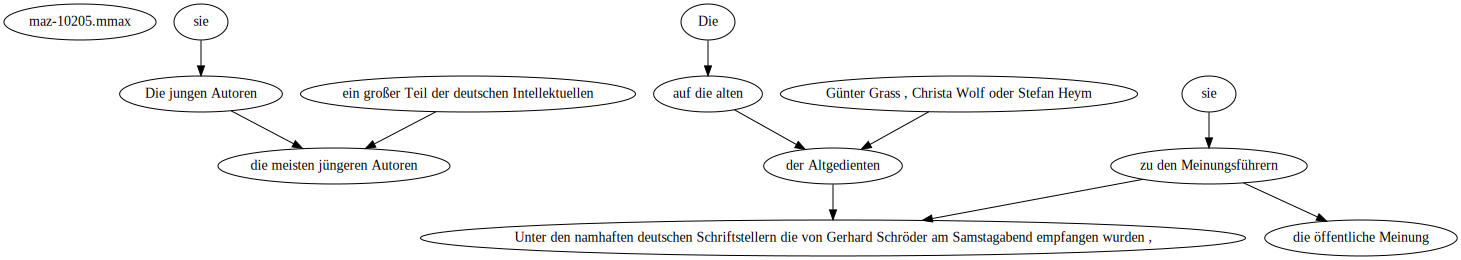

In [72]:
%dotstr dg.print_dot(docs_with_merged_chains.items()[0][1])

In [37]:
def merge_ambiguous_chains(ambiguous_chains):
    """
    Parameters
    ----------
    ambiguous_chains : list of MultiDiGraph
        a list of graphs, each representing an ambiguous coreference chain
    """
    merged_chain = nx.DiGraph(nx.compose_all(ambiguous_chains))
    merged_chain.add_node('name', shape='tab',
                          color='blue',
                          label=ambiguous_chains[0].name)
    for node in merged_chain:
        if merged_chain.in_degree(node) > 1 \
        or merged_chain.out_degree(node) > 1:
            merged_chain.node[node]['color'] = 'red'
    return merged_chain

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-10205.mmax


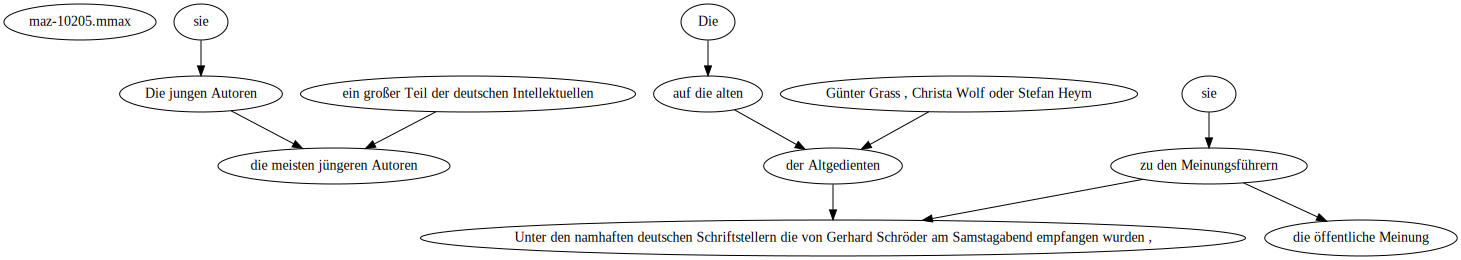

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-18480.mmax


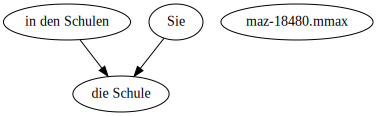

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-17539.mmax


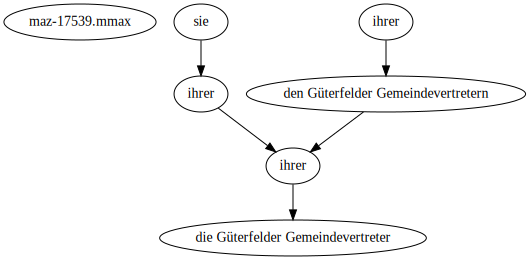

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-19372.mmax


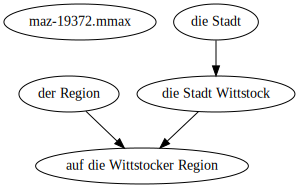

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-14399.mmax


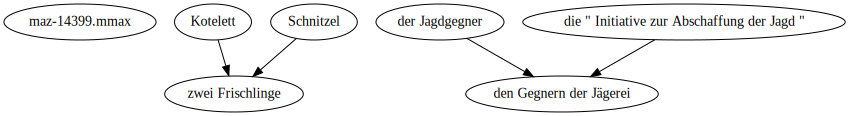

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-18712.mmax


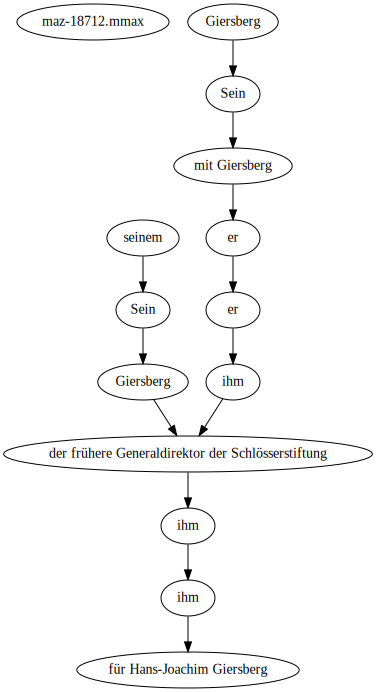

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-1453.mmax


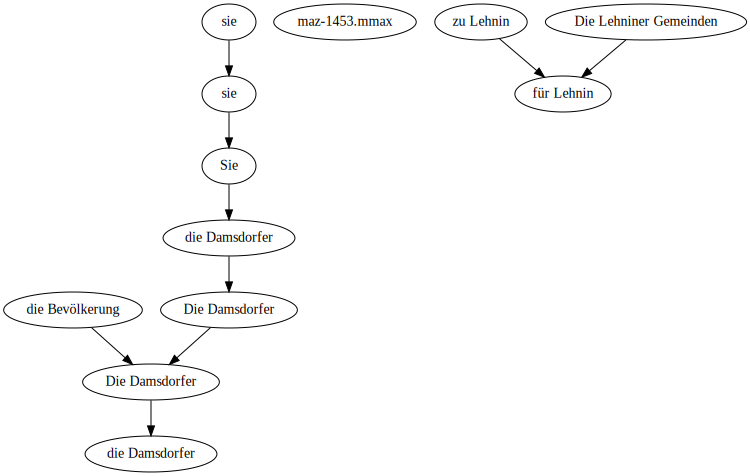

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-16294.mmax


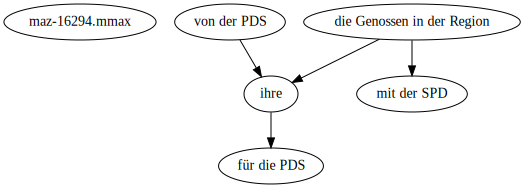

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-6488.mmax


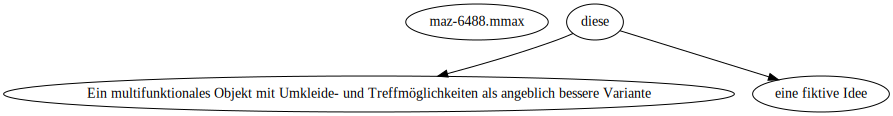

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-8134.mmax


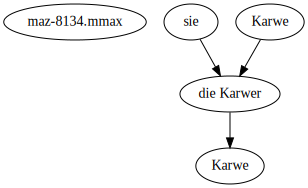

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-19074.mmax


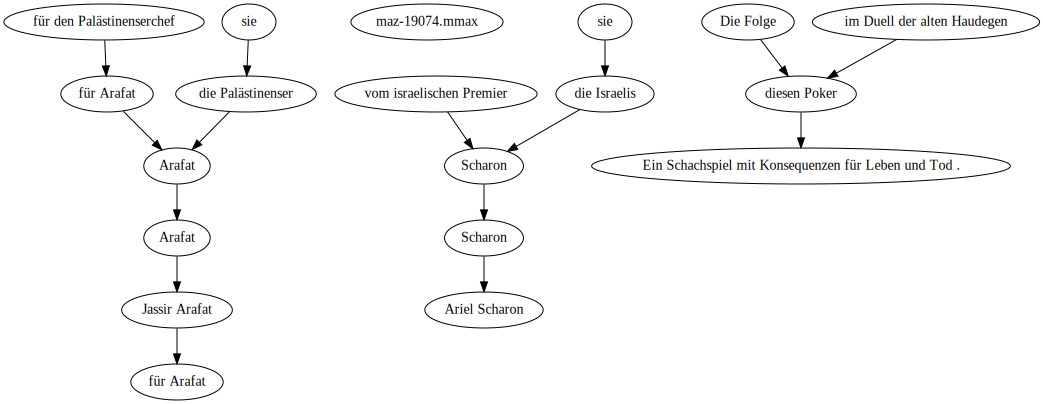

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-18377.mmax


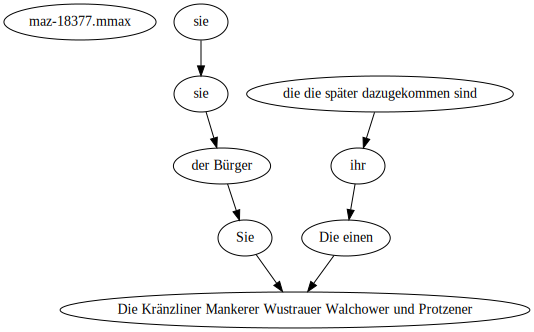

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-9884.mmax


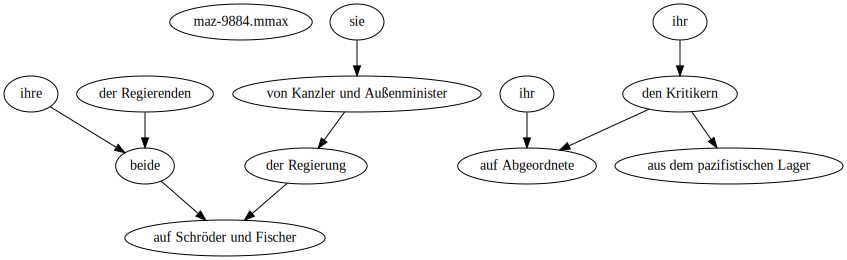

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-00001.mmax


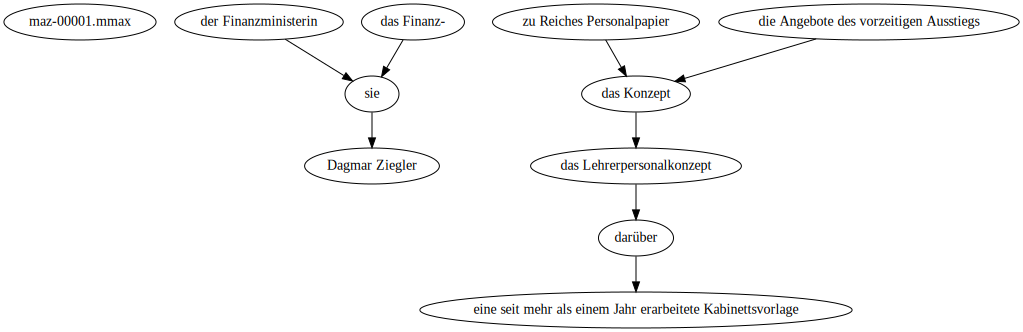

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-18171.mmax


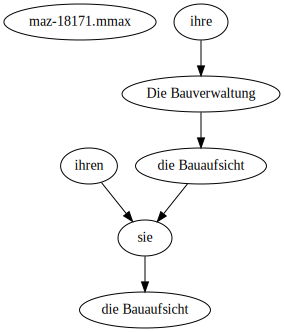

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-3377.mmax


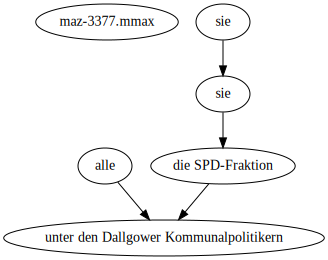

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-3073.mmax


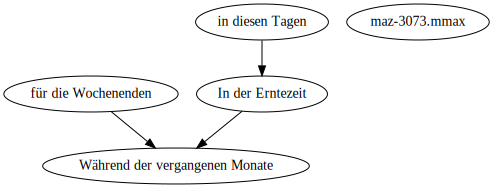

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-10207.mmax


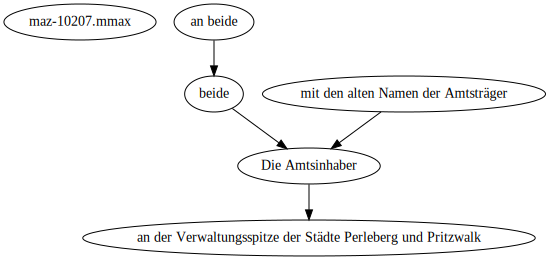

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-18354.mmax


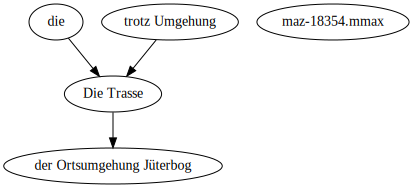

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-11299.mmax


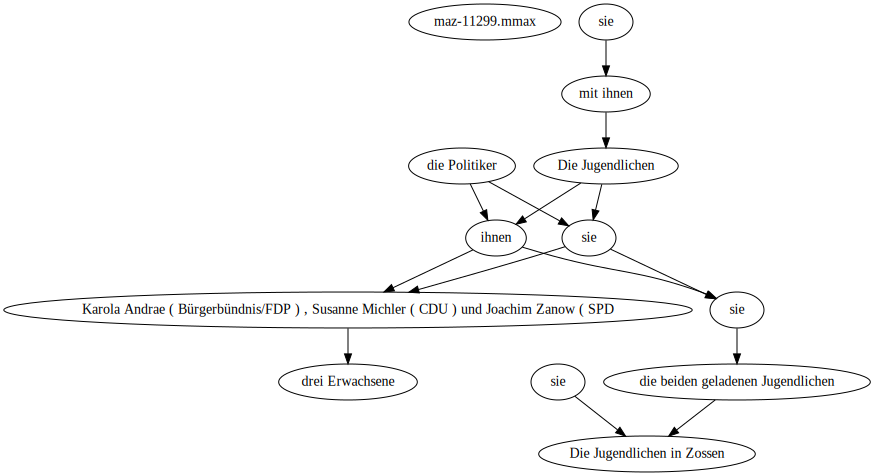

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-2611.mmax


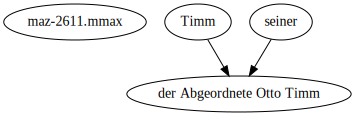

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-12576.mmax


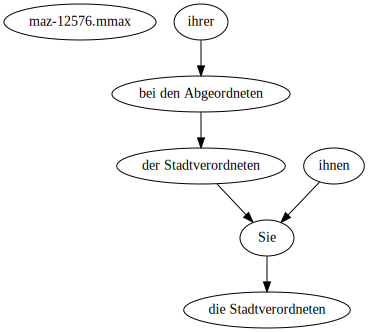

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-6728.mmax


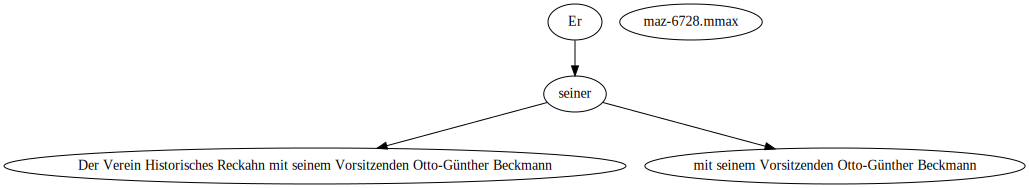

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-16987.mmax


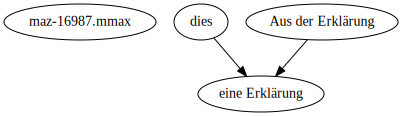

/home/arne/repos/pcc-development-repo/maz176/coreference/maz-13915.mmax


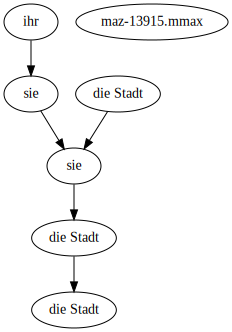

In [73]:
for doc in docs_with_merged_chains:
    print doc
    %dotstr dg.print_dot(docs_with_merged_chains[doc])
#     dg.print_dot(merged_graph)

# %dotstr dg.print_dot(docs_with_ambiguous_chains[docs_with_ambiguous_chains.keys()[0]][0])

In [76]:
dg.get_text(dg.read_mmax2('/home/arne/repos/pcc-development-repo/maz176/coreference/maz-9884.mmax'))

u'Dilemma Verrat , hat Talleyrand einmal zynisch bemerkt , ist nur eine Frage des Datums . Und des Gewissens , m\xf6chte man mit Blick auf Schr\xf6der und Fischer hinzuf\xfcgen . Nicht , dass beide eine Mehrheit f\xfcr ihre Koalition suchten , war das \xc4rgerliche in den vergangenen Tagen , sondern das Wie , der Druck auf Abgeordnete , die kein Regierungsamt haben und ihr Gewissen deshalb auch nicht in den Vorzimmern der Macht abgeben k\xf6nnen . Gut , dass wir eine rot-gr\xfcne Koalition haben , sto\xdfseufzen viele hinter vorgehaltener Hand , andernfalls w\xfcrde die Republik brennen . Und das ist das Dilemma der Regierenden . Wer in der Zeit , da er noch nach \xc4mtern strebte , mit eben denselben Argumenten , die heute aus dem pazifistischen Lager der Regierung entgegenschallen , Kohl , Genscher und Kinkel verteufelte , hat kein Recht , den Kritikern ihr Gewissen abzusprechen . Die anf\xe4ngliche \xdcberreaktion von Kanzler und Au\xdfenminister hat eben auch damit zu tun , dass si

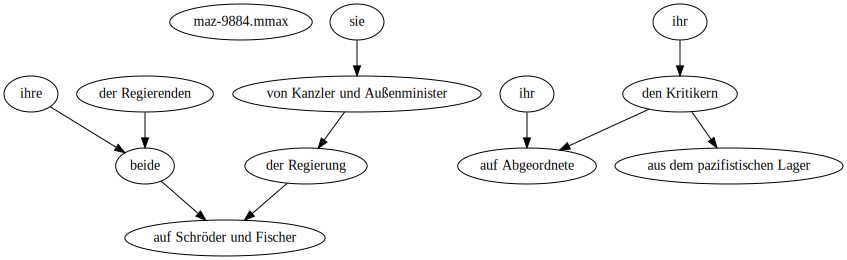

In [80]:
%dotstr dg.print_dot(docs_with_merged_chains['/home/arne/repos/pcc-development-repo/maz176/coreference/maz-9884.mmax'])

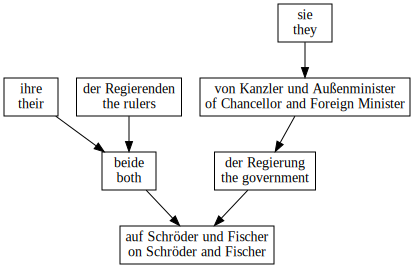

In [91]:
simple_digraph = u"""
digraph "maz-9884.mmax" {
"markable_38" [label="auf Schröder und Fischer"];
"markable_39" [label="beide"];
"markable_97" [label="von Kanzler und Außenminister"];
"markable_40" [label="ihre"];
"markable_66" [label="sie"];
"markable_58" [label="der Regierung"];
"markable_53" [label="der Regierenden"];

"markable_39" -> "markable_38"  [key=0];
"markable_97" -> "markable_58"  [key=0];
"markable_40" -> "markable_39"  [key=0];
"markable_66" -> "markable_97"  [key=0];
"markable_58" -> "markable_38"  [key=0];
"markable_53" -> "markable_39"  [key=0];
}"""

simple_digraph2 = u"""
digraph "maz-9884.mmax" {
"markable_38" [shape=box, label="auf Schröder und Fischer\non Schröder and Fischer"];
"markable_39" [shape=box, label="beide\nboth"];
"markable_97" [shape=box, label="von Kanzler und Außenminister\nof Chancellor and Foreign Minister"];
"markable_40" [shape=box, label="ihre\ntheir"];
"markable_66" [shape=box, label="sie\nthey"];
"markable_58" [shape=box, label="der Regierung\nthe government"];
"markable_53" [shape=box, label="der Regierenden\nthe rulers"];

"markable_39" -> "markable_38"  [key=0];
"markable_97" -> "markable_58"  [key=0];
"markable_40" -> "markable_39"  [key=0];
"markable_66" -> "markable_97"  [key=0];
"markable_58" -> "markable_38"  [key=0];
"markable_53" -> "markable_39"  [key=0];
}"""

%dotstr simple_digraph2